## LSTMを用いた時系列予測(回帰)
株価予測への応用として、LSTM(Long Short Term Memory)を用いて、過去のデータから未来のデータの予測を行ってみる. 今回はJALの過去一年の株価データを用いる. \
ソース: https://finance.yahoo.com/quote/JAL.F/history?p=JAL.F

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
#データのインポート
df = pd.read_csv("JAL.F.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-08-05,16.524000,16.524000,16.524000,16.524000,16.524000,0
1,2021-08-06,16.584000,16.584000,16.584000,16.584000,16.584000,0
2,2021-08-09,16.643999,16.643999,16.643999,16.643999,16.643999,0
3,2021-08-10,17.214001,17.214001,17.214001,17.214001,17.214001,0
4,2021-08-11,17.614000,17.614000,17.614000,17.614000,17.614000,0


In [3]:
#欠損地の有無を調べる
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       258 non-null    object 
 1   Open       258 non-null    float64
 2   High       258 non-null    float64
 3   Low        258 non-null    float64
 4   Close      258 non-null    float64
 5   Adj Close  258 non-null    float64
 6   Volume     258 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 14.2+ KB


In [4]:
#データ型を'datetime'に変換
df['Date']=pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       258 non-null    datetime64[ns]
 1   Open       258 non-null    float64       
 2   High       258 non-null    float64       
 3   Low        258 non-null    float64       
 4   Close      258 non-null    float64       
 5   Adj Close  258 non-null    float64       
 6   Volume     258 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 14.2 KB


In [5]:
#日付をデータとして扱うため、日付をindexにセットする
df.set_index(keys='Date',inplace=True)
df

#データの並び替え
df.sort_values(by='Date',ascending=True,inplace=True)

<AxesSubplot:xlabel='Date'>

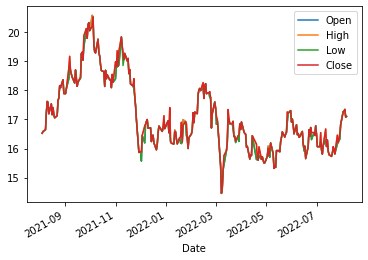

In [6]:
df_plot = df[['Open','High','Low','Close']]

%matplotlib inline 

df_plot.plot(kind='line')

## 予測する値
始値、高値、安値を特徴量として、特徴量から翌日の終値を予測する.

In [12]:
#特徴量とターゲットを抽出
target_y = df.iloc[:,3]
X_feat = df.iloc[:,0:3]

X_feat

,Open,High,Low
Date,,,
2021-08-05,16.524000,16.524000,16.524000
2021-08-06,16.584000,16.584000,16.584000
2021-08-09,16.643999,16.643999,16.643999
2021-08-10,17.214001,17.214001,17.214001
2021-08-11,17.614000,17.614000,17.614000
...,...,...,...
2022-08-01,17.264999,17.264999,17.264999
2022-08-02,17.280001,17.280001,17.280001
2022-08-03,17.340000,17.340000,17.340000


In [13]:
target_y

Date
2021-08-05    16.524000
2021-08-06    16.584000
2021-08-09    16.643999
2021-08-10    17.214001
2021-08-11    17.614000
                ...    
2022-08-01    17.264999
2022-08-02    17.280001
2022-08-03    17.340000
2022-08-04    17.075001
2022-08-05    17.100000
Name: Close, Length: 258, dtype: float64

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

#前処理として標準化をする
sc = StandardScaler()
X_ft = sc.fit_transform(X_feat)
X_ft = pd.DataFrame(columns=X_feat.columns,
                    data=X_ft,
                    index=X_feat.index)

X_ft

,Open,High,Low
Date,,,
2021-08-05,-0.470524,-0.507872,-0.468598
2021-08-06,-0.420908,-0.458431,-0.418779
2021-08-09,-0.371293,-0.408992,-0.368961
2021-08-10,0.100063,0.060697,0.104317
2021-08-11,0.430838,0.390300,0.436441
...,...,...,...
2022-08-01,0.142236,0.102720,0.146662
2022-08-02,0.154641,0.115081,0.159118
2022-08-03,0.204257,0.164521,0.208936


In [15]:
target_y = target_y.to_numpy()
target_y = target_y.reshape(-1,1)
target_y = sc.fit_transform(target_y)
target_y = pd.DataFrame(columns=['Close'],data=target_y,index=X_feat.index)

target_y


,Close
Date,
2021-08-05,-0.505374
2021-08-06,-0.455852
2021-08-09,-0.406330
2021-08-10,0.064137
2021-08-11,0.394287
...,...
2022-08-01,0.106230
2022-08-02,0.118612
2022-08-03,0.168134


In [16]:
#Xとyをn個の時系列ブロックに変換
def lstm_split(X_feat,y_target,n_steps):
    X,y = [],[]
    for i in range(len(X_feat)-n_steps+1):
        X.append(X_feat[i:i+n_steps])
        y.append(y_target[i+n_steps-1])
    
    return np.array(X),np.array(y)

In [17]:
#今回は現在から4日前までのデータから現在の終値を予測する
n_steps = 4
X1,y1 = lstm_split(X_feat.values,target_y.values,n_steps=n_steps)

split_idx = int(np.ceil(len(X1)*0.8))
date_index = X_feat.index
date_index = date_index[:len(date_index)-n_steps+1]

X_train,X_test = X1[:split_idx], X1[split_idx:]
y_train,y_test = y1[:split_idx], y1[split_idx:]
train_date,test_date = date_index[:split_idx],date_index[split_idx:]

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(204, 4, 3)
(204, 1)
(51, 4, 3)
(51, 1)


In [19]:
date_index.shape

(255,)

## LSTMモデル
まずは単純なLSTMモデルから試す

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models

print(tf.__version__)

2.8.0


In [21]:
class LSTM_Model(tf.keras.Model):
    def __init__(self):
        super(LSTM_Model,self).__init__()
        self.lstm1 = layers.LSTM(32,activation='relu',return_sequences=True)
        self.fc1 = layers.Dense(1)
    
    def call(self,X):
        X = self.lstm1(X)
        X = self.fc1(X)

        return X

model = LSTM_Model()
model.compile(loss='mean_squared_error',optimizer='adam')
model.build((None,4,3))
model.summary()

Model: "lstm__model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 multiple                  4608      
                                                                 
 dense (Dense)               multiple                  33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(X_train,y_train,epochs=50,batch_size=4,verbose=2,shuffle=False)

Epoch 1/50
51/51 - 0s - loss: 0.4874 - 163ms/epoch - 3ms/step
Epoch 2/50
51/51 - 0s - loss: 0.4712 - 129ms/epoch - 3ms/step
Epoch 3/50
51/51 - 0s - loss: 0.4850 - 135ms/epoch - 3ms/step
Epoch 4/50
51/51 - 0s - loss: 0.4702 - 142ms/epoch - 3ms/step
Epoch 5/50
51/51 - 0s - loss: 0.4826 - 138ms/epoch - 3ms/step
Epoch 6/50
51/51 - 0s - loss: 0.4694 - 130ms/epoch - 3ms/step
Epoch 7/50
51/51 - 0s - loss: 0.4802 - 143ms/epoch - 3ms/step
Epoch 8/50
51/51 - 0s - loss: 0.4685 - 146ms/epoch - 3ms/step
Epoch 9/50
51/51 - 0s - loss: 0.4779 - 162ms/epoch - 3ms/step
Epoch 10/50
51/51 - 0s - loss: 0.4678 - 148ms/epoch - 3ms/step
Epoch 11/50
51/51 - 0s - loss: 0.4755 - 165ms/epoch - 3ms/step
Epoch 12/50
51/51 - 0s - loss: 0.4670 - 159ms/epoch - 3ms/step
Epoch 13/50
51/51 - 0s - loss: 0.4729 - 154ms/epoch - 3ms/step
Epoch 14/50
51/51 - 0s - loss: 0.4660 - 157ms/epoch - 3ms/step
Epoch 15/50
51/51 - 0s - loss: 0.4702 - 185ms/epoch - 4ms/step
Epoch 16/50
51/51 - 0s - loss: 0.4648 - 201ms/epoch - 4ms/step
E

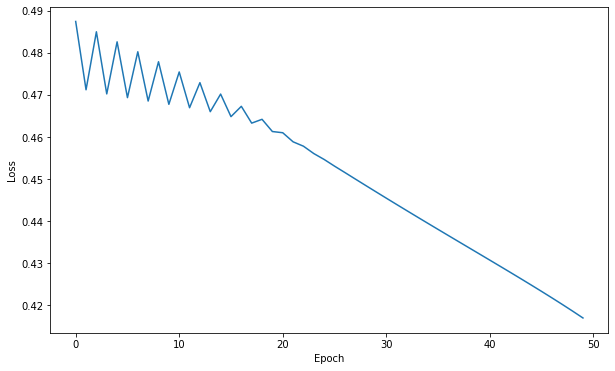

In [31]:
#epoch-lossの描画
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [32]:
#予測
y_pred = model.predict(X_test)
y_pred = y_pred[:,3,:]

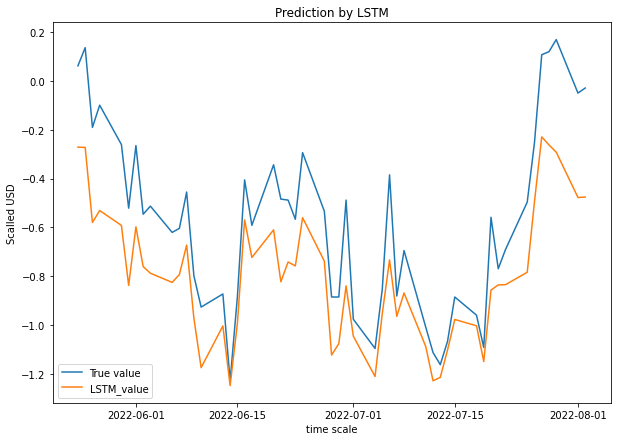

In [33]:
#y_testとy_predをプロットする

plt.figure(figsize=(10,7))
plt.plot(test_date,y_test,label="True value")
plt.plot(test_date,y_pred,label="LSTM_value")
plt.xlabel("time scale")
plt.ylabel("Scalled USD")
plt.title("Prediction by LSTM")
plt.legend(loc='best')
plt.show()

In [27]:
rmse = mean_squared_error(y_test,y_pred,squared=False)
mape = mean_absolute_percentage_error(y_test,y_pred)
print("RSME: ", rmse)
print("MAPE: ",mape)

RSME:  0.6184121281908309
MAPE:  2.47092105785729
